# General Concepts (with a time dependent problem)
In the following we introduce how to construct and use the basic components of
a finite element method ending the first part with solving a simple Laplace
problem. The required steps are:

*  constructing a tessellation of the computational domain (**hierarchical grid** and **grid view**)
*  working with functions defined over the grid (**grid functions**)
*  setting up **discrete spaces** and **discrete functions**
*  defining the mathematical model to solve (**ufl**)
*  solving the (non linear) system arising from the discretization of the
   model by the Galerkin method (**scheme**)

.. index::
   pair: Grids; Grid Definition

## Setting up the Grid

.. note:: The goal of a Dune **grid** or **hierarchical grid** is to provide an
interface to describe subdivisions (entities or elements for codim 0) of the computational domain $\Omega$
in a generic way. In the following this is referred to as `hierarchicalGrid`. See <cite data-cite="DuneReview"></cite>, Section 3.1, for
more details.

After some general import statements we start our tutorial by setting up
a simple Cartesian grid over the domain $\Omega = [0,1]^2$ subdivided into four
intervals in each dimension. We can then show the grid using the `plot`
method - note that direct plotting with MatPlotLib is only supported in
2D, other options for visualization, e.g., using ParaView will be
discussed later.

Using the `dune.grid.structuredGrid` function, is the simplest way to construct
a grid, more complicated
(unstructured) grids can be constructed using a dictionary containing the
vertices and the element connectivity or by for example providing a
`gmsh` file. This will be discussed in later section, see for example
here for [a 3d gmsh file](othergrids_nb.ipynb)
or here [for a simple example using a dictionary](dune-corepy_nb.ipynb#An-unstructured-grid).

.. index::
   pair: Grids; Plotting


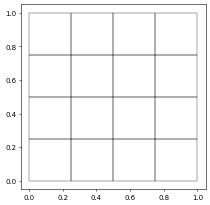

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from dune.grid import structuredGrid as leafGridView
gridView = leafGridView([0, 0], [1, 1], [4, 4])
gridView.plot()

Often the initial grid is a bit coarse - it is very easy to refine it
globally.
Grids can be refined in a hierarchic manner, meaning that elements are subdivided into several smaller elements. The
element to be refined is kept in the grid and remains accessible.
We will discuss [local refinement](gridviews.rst#Dynamic-Local-Grid-Refinement-and-Coarsening)
in a later section.

.. note:: A **grid view** object provides read-only access to the entities of all codimensions in the view, i.e. a subset of the hierarchical grid.
In the following this is called `gridView` and sometimes abbreviated as `grid`. See <cite data-cite="DuneReview"></cite>, Section 3.1.1, for more details.

Note that the ``gridView`` we have constructed can not be changed
directly (i.e. read-only access), we need to access the underlying ``hierarchicalGrid``:

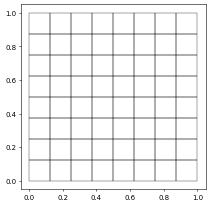

In [2]:
from dune.fem import globalRefine
globalRefine(1,gridView.hierarchicalGrid) # the first argument is the number of refinements to perform
gridView.plot()

.. index::
   pair: Functions; Grid Functions

## Grid Functions

.. note:: A **grid functions** is a functions that is defined
over a given grid view and is evaluated by using an element
of this view and local coordinate within that element, i.e. a quadrature point.

For example:
```
   value = gridFunction(element,localCoordinate)
```
Alternatively one can obtain a `LocalFunction` from a grid function which
can be bound to an element and then evaluate via local coordinate:
```
   localFunction = gridFunction.localFunction()
   for e in grid.elements:
       localFunction.bind(e)
       value = localFunction(x)
       localFunction.unbind()
```
There are multiple ways to construct grid functions. The easiest way it
to use UFL expression. Many methods expecting grid functions are argument
can also directly handle UFL expression.
We can for example integrate a UFL expression over the grid:

In [3]:
from ufl import SpatialCoordinate, triangle
x = SpatialCoordinate(triangle)

exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

from dune.fem.function import integrate
print( integrate(gridView, exact, order=5) )

1.3333333333333324


.. index::
   pair: I/O; VTK files

and plot them using matplotlib or write a vtk file for postprocessing

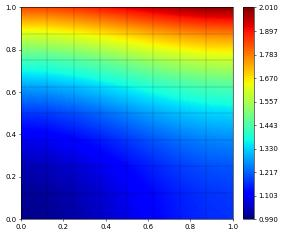

In [4]:
from dune.fem.plotting import plotPointData as plot
plot(exact, grid=gridView)
gridView.writeVTK('exact', pointdata={'exact': exact})

In some cases it can be necessary to convert a UFL expression into a grid
function explicitly - for example to be able to evaluate it over each
element in the grid ([in a later section](dune-corepy_nb.ipynb)
we provide more detail on how to access the grid interface).

In [5]:
from dune.fem.function import uflFunction
exact_gf = uflFunction(gridView, name="ufl", order=1, ufl=exact)
mass = 0
for element in gridView.elements:
    mass += exact_gf(element,[0.5,0.5]) * element.geometry.volume
print(mass)

1.33203125


.. index::
   triple: Functions; Grid Functions; Decorator

Another way to obtain a grid function is to use the `gridFunction`
decorator. This can be obtained from `dune.grid` but then without UFL
support. Using the decorator from `dune.fem.function` the resulting grid
function can be used seamlessly within UFL expressions:

In [6]:
from dune.fem.function import gridFunction
@gridFunction(gridView,name="callback",order=1)
def exactLocal(element,xLocal):
    x = element.geometry.toGlobal(xLocal)
    return 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

we can use the same approach but with a function using global
coordinates but can then be used like any other grid function:

In [7]:
@gridFunction(gridView,name="callback",order=1)
def exactGlobal(x):
    return 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

lf = exactGlobal.localFunction()

mass = 0
for element in gridView.elements:
    lf.bind(element)
    mass += lf([0.5,0.5]) * element.geometry.volume
    lf.unbind()
print(mass)

1.33203125


.. index::
   pair: Functions; UFL functions

As pointed out the `dune.fem` grid function can be used like any other
UFL coefficient to form UFL expressions:

0.0


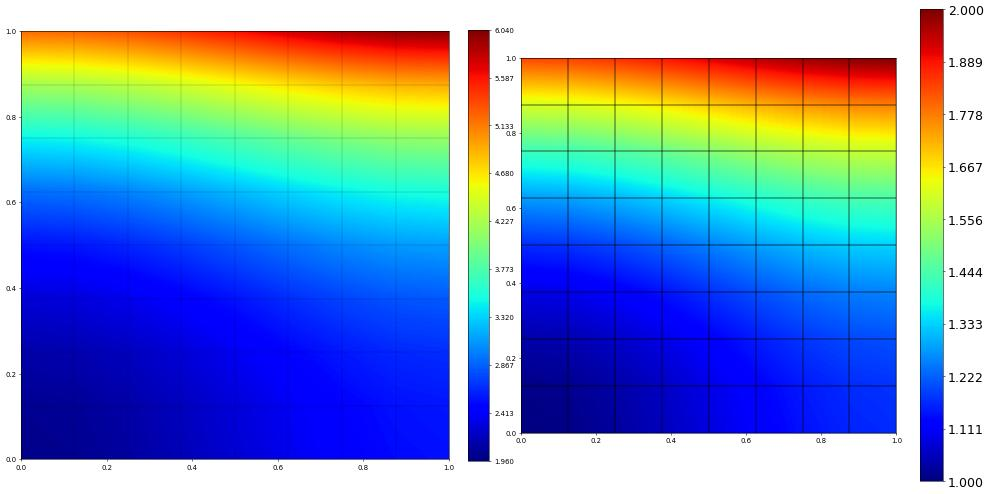

In [8]:
print( integrate(gridView, abs(exact-exactLocal), order=5) )
gf = uflFunction(gridView, name="ufl", order=1, ufl=exact+exactLocal*exactGlobal)
fig = plt.figure(figsize=(20,10))
gf.plot(figure=(fig,121))
exactGlobal.plot(figure=(fig,122))

Converting UFL expressions to grid functions leads to JIT code generation
and is therefore efficient when used in other C++ algorithm (like
`integrate`). But more complex control structures are hard to express
within UFL. On the other hand using the `gridFunction` decorator leads
to a callback into Python for each evaluation and is therefore much less
efficient. An alternative approach is based on writing small C++ snippets
implementing the grid function as described in the section on
generating
[C++ Based Grid Functions](cppfunctions_nb.ipynb).


.. index::
   pair: Functions; Discrete Functions

.. index::
   pair: Spaces; Lagrange Space

## Discrete Spaces and Discrete Functions

The grid functions set up so far did not involve any
discretization, they are exactly evaluated at the given point.

.. note::
A **discrete (function) space** is a finite dimensional function space defined over a given grid view,
typically the Finite Element space involved.


In [9]:
from dune.fem.space import lagrange as solutionSpace
space = solutionSpace(gridView, order=2)


A list of available spaces is shown at the bottom of this page.

.. note::
A special type of grid function is a **discrete function** living in a
discrete (finite dimensional) space.

The easiest way to construct a discrete function is to use the `interpolate`
method on the discrete function space to create an initialized discrete
function or `function` to create an uninitialized discrete function.

In [10]:
# initialized
u_h = space.interpolate(exact, name='u_h')

# uninitialized
u_h = space.function(name='u_h')

On an existing discrete function the `interpolate` method can be used to
reinitialize it

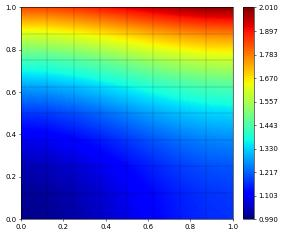

In [11]:
u_h.interpolate( lambda x: 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1 )
u_h.plot()

Note that in the last example the Python lambda is used as a callback
automatically using the same concept used in the `gridFunction`
decorator. As pointed out above there are some methods where these
conversions are implicit and no explicit generation of a grid function
has to be carried out.

If a discrete function is already available it is possible to call `copy`
to obtain further discrete functions:

In [12]:
u_h_n = u_h.copy(name="previous")

Finally, `clear` can be called on a discrete function which sets all
coefficient to zero and `assign` can be used to copy all coefficients
between two discrete function over the same space:

In [13]:
u_h_n.clear()
u_h_n.assign( u_h )

All the things we did above with grid functions can be done with discrete
functions, e.g., evaluate locally

In [14]:
localUh = u_h.localFunction()
mass = 0
for element in gridView.elements:
    localUh.bind(element) # using u_h(element,[0.5,0.5]) also works
    mass += localUh([0.5,0.5]) * element.geometry.volume
    localUh.unbind()
print(mass)

1.33203125


.. index::
   pair: Functions; Plotting

.. index::
   pair: I/O; VTK files

or plot using matplotlib and write a vtk file for postprocessing
(using binary data format to reduce size)

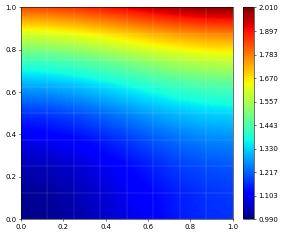

In [15]:
u_h.plot(gridLines="white")
from dune.grid import OutputType
gridView.writeVTK('uh', pointdata=[u_h])

Note: the discrete function `u_h` already has a `name` attribute given in
the `interpolate` call. This is used by default in the vtk file. An
alternative name can be given by using a dictionary as shown previously.

Of course a discrete function can also be used as a coefficient in a UFL expression

In [16]:
print( integrate(gridView, abs(exact-u_h), order=5) )

2.0234046867290766e-05


The main difference between a grid function and a discrete function is
that the latter has a `dofVector` attached to it. We can iterate over
that easily

In [17]:
for d in u_h.dofVector:
    print(d,end=", ")
print()

1.0, 1.0071614583333333, 1.0260416666666667, 1.052734375, 1.0833333333333333, 1.1139322916666667, 1.140625, 1.1595052083333333, 1.1666666666666667, 1.0084635416666667, 1.015625, 1.0345052083333333, 1.0611979166666667, 1.091796875, 1.1223958333333333, 1.1490885416666667, 1.16796875, 1.1751302083333335, 1.0364583333333333, 1.0436197916666667, 1.0625, 1.0891927083333333, 1.1197916666666667, 1.150390625, 1.1770833333333333, 1.1959635416666667, 1.203125, 1.087890625, 1.0950520833333333, 1.1139322916666667, 1.140625, 1.1712239583333333, 1.2018229166666667, 1.228515625, 1.2473958333333333, 1.2545572916666667, 1.1666666666666667, 1.173828125, 1.1927083333333333, 1.2194010416666667, 1.25, 1.2805989583333333, 1.3072916666666667, 1.326171875, 1.3333333333333335, 1.2766927083333333, 1.2838541666666665, 1.302734375, 1.3294270833333333, 1.3600260416666667, 1.390625, 1.4173177083333333, 1.4361979166666667, 1.443359375, 1.421875, 1.4290364583333333, 1.4479166666666665, 1.474609375, 1.5052083333333335,

In addition to `clear` and `assign` we can also add (scalar
multiples of) discrete functions together or multiply them by a scalar
which will directly change the underlying dofVector - this can only be
done __in place__, so `u_h *= 2` changes the dof vector while
`u_h*2` results in an UFL expression. Here are some examples:

In [18]:
u_h_n *= 2
u_h   += u_h_n
# this is equivalent to
u_h.axpy(2,u_h_n)

We started with `u_h_n=u_h` so after these changes each dof in
`u_h` should be seven times its original value

In [19]:
for d in u_h.dofVector:
    print(d,end=", ")
print()

7.0, 7.050130208333333, 7.182291666666667, 7.369140625, 7.583333333333333, 7.797526041666667, 7.984375, 8.116536458333332, 8.166666666666668, 7.059244791666667, 7.109375, 7.241536458333333, 7.428385416666667, 7.642578125, 7.856770833333333, 8.043619791666668, 8.17578125, 8.225911458333334, 7.255208333333333, 7.305338541666667, 7.4375, 7.624348958333333, 7.838541666666667, 8.052734375, 8.239583333333332, 8.371744791666668, 8.421875, 7.615234375, 7.665364583333333, 7.797526041666667, 7.984375, 8.198567708333332, 8.412760416666668, 8.599609375, 8.731770833333332, 8.781901041666668, 8.166666666666668, 8.216796875, 8.348958333333332, 8.535807291666668, 8.75, 8.964192708333332, 9.151041666666668, 9.283203125, 9.333333333333334, 8.936848958333332, 8.986979166666666, 9.119140625, 9.305989583333332, 9.520182291666668, 9.734375, 9.921223958333332, 10.053385416666668, 10.103515625, 9.953125, 10.003255208333332, 10.135416666666666, 10.322265625, 10.536458333333334, 10.750651041666666, 10.9375, 11.

[In a later section](solvers_nb.ipynb)
we will see how to extract the underlying dof vector in the form of a `numpy` or a `petsc` vector.

.. index::
   pair: Models; Constants

## Handling constant parameters

We have already seen how grid function can be used within UFL expressions
and forms - in the [next section](dune-fempy_nb.ipynb) we will give another example for this in the
context of a time dependent problems. In addition we can also use the
`Constant` class to add constants to UFL expressions/forms which then can
be changed without requiring any recompilation of the model. An example
would again be in a time dependent problem a time varying coefficient.
Being able to change the value of the time in the model without
recompilation is crucial for an efficient code. We will demonstrate this
here by considering
$$ -\triangle u + \alpha u = f $$

where $\alpha$ is a real valued parameter.
We choose $f,g_N,g_D$ so that the exact solution for $\alpha=0$
is given by
\begin{align*}
u(x) = \left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}
which is the grid function ``exact`` we have already defined above.

.. index:: Scheme; Scheme Definition

Although the problem is linear and we could just use
``dune.fem.assemble`` and Scipy to solve, we use a ``scheme`` instead.

.. note:: A **scheme** implements the weak form a specific type of equation,
where the mathematical model (integrands) is provided as ufl form.


In [20]:
from ufl import (TestFunction, TrialFunction, SpatialCoordinate, FacetNormal,
                 dx, ds, grad, div, inner, dot, sin, cos, pi, conditional)
from dune.ufl import Constant, DirichletBC
from dune.fem.scheme import galerkin as solutionScheme

alpha = Constant(1,name="mass")   # start with alpha=1
x     = SpatialCoordinate(space)
u     = TrialFunction(space)
v     = TestFunction(space)
f     = -div( grad(exact) )
g_N   = grad(exact)
n     = FacetNormal(space)
b     = f*v*dx + dot(g_N,n)*conditional(x[0]>=1e-8,1,0)*v*ds
a     = dot(grad(u), grad(v)) * dx + alpha*u*v * dx
dbc   = DirichletBC(space,exact,x[0]<=1e-8)

scheme = solutionScheme([a == b, dbc], solver='cg')
scheme.solve(target = u_h)

h1error = dot(grad(u_h - exact), grad(u_h - exact))
error = np.sqrt(integrate(gridView, h1error, order=5))
print("Number of elements:",gridView.size(0),
      "number of dofs:",space.size,"H^1 error:", error)

Number of elements: 64 number of dofs: 289 H^1 error: 0.5635700799029998



Note that $\alpha=1$ so we do not have the correct exact solution.
We can print the value of a `Constant` with name `foo` via
`scheme.model.foo` and change it's value using the same attribute:

In [21]:
print(scheme.model.mass)
scheme.model.mass = 0      # change to the problem which matches our exact solution
print(scheme.model.mass)

scheme.solve(target = u_h)

h1error = dot(grad(u_h - exact), grad(u_h - exact))
error = np.sqrt(integrate(gridView, h1error, order=5))
print("Number of elements:",gridView.size(0),
      "number of dofs:",space.size,"H^1 error:", error)

1.0
0.0


Number of elements: 64 number of dofs: 289 H^1 error: 0.0016470196146885557


.. index:: Equations; Non-linear parabolic

## A Nonlinear Time Dependent Problem

As a second example we will study the Forchheimer problem
<cite data-cite="Kieu"></cite>
which is a scalar, nonlinear parabolic equation
\begin{equation}
\partial_tu - \nabla\cdot K(\nabla u)\nabla u = f
\end{equation}
where the diffusion tensor is given by
\begin{equation}
K(\nabla u) = \frac{2}{1+\sqrt{1+4|\nabla u|}}
\end{equation}
and $f=f(x,t)$ is some time dependent forcing term.
On the boundary we prescribe Neumann boundary as before
and initial conditions $u=u_0$.

We will solve this problem in variational form and using Crank Nicolson in time

\begin{equation}
\begin{split}
\int_{\Omega} \frac{u^{n+1}-u^n}{\Delta t} \varphi
+ \frac{1}{2}K(\nabla u^{n+1}) \nabla u^{n+1} \cdot \nabla \varphi \
+ \frac{1}{2}K(\nabla u^n) \nabla u^n \cdot \nabla \varphi v\ dx \\
- \int_{\Omega} \frac{1}{2}(f(x,t^n)+f(x,t^n+\Delta t) \varphi\ dx
- \int_{\partial \Omega} \frac{1}{2}(g(x,t^n)+g(x,t^n+\Delta t)) v\ ds
= 0.
\end{split}
\end{equation}

on a domain $\Omega=[0,1]^2$. We choose $f,g$ so that the exact solution
is given by
\begin{align*}
u(x,t) = e^{-2t}\left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}
We solve this problem using a quadratic finite element space.
We first setup this space, define the initial data,
and a second discrete function to store
the solution at the current time step (``u_h`` will be used to store the
next time step):

In [22]:
space = solutionSpace(gridView, order=2)
u_h   = space.interpolate(0, name='u_h')
u_h_n = u_h.copy(name="previous")

x = SpatialCoordinate(space)
initial = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

Next we setup the form $a=a(u,v)$ which depends on time $t$ and the
chosen time step $\Delta t$. Since we want to be able to change these
during the simulation (we need to do this for $t$ and might want to do
this for $\Delta t$ we use the ``dune.ufl.Constant`` which stores a
mutable scalar and can be used within a ufl expression:

In [23]:
from ufl import FacetNormal, ds, div, dot, sqrt, exp
from dune.ufl import Constant
dt = Constant(0, name="dt")    # time step
t  = Constant(0, name="t")     # current time
u = TrialFunction(space)
v = TestFunction(space)

abs_du = lambda u: sqrt(inner(grad(u), grad(u)))
K = lambda u: 2/(1 + sqrt(1 + 4*abs_du(u)))
a = ( dot((u - u_h_n)/dt, v) \
    + 0.5*dot(K(u)*grad(u), grad(v)) \
    + 0.5*dot(K(u_h_n)*grad(u_h_n), grad(v)) ) * dx

To define the right hand side we use the given function $u$ to define
the forcing $f$ and the boundary flux $g$

In [24]:
exact = lambda t: exp(-2*t)*(initial - 1) + 1
f     = lambda s: -2*exp(-2*s)*(initial - 1) - div( K(exact(s))*grad(exact(s)) )
g = lambda s: K(exact(s))*grad(exact(s))
n = FacetNormal(space)
b = 0.5*(f(t)+f(t+dt))*v*dx + 0.5*dot(g(t)+g(t+dt),n)*v*ds

With the model described as a ufl form, we can again construct a scheme class
that provides the solve method which we can use to evolve the solution from
one time step to the next. As already mentioned the solve methods always assumes
that the problem is non-linear and use a Newton method to solve the problem:

In [25]:
scheme = solutionScheme(a == b, solver='cg')


Optionally, we may want to increase the default quadrature orders which are
`2 * space.order` for element integrals and `2 * space.order + 1` for surface
integrals. Depending on the data this might not be enough. Then we simply
set the integration orders by hand like in the following example, by calling
the method setQuadratureOrders(interiorOrder, surfaceOrder).

In [26]:
#scheme.setQuadratureOrders( 2*space.order, 2*space.order+1 )


.. index:: Experimental Order of Convergence (EOC)

Since we have forced the system towards a given solution, we can compute
the discretization error. First we define ufl expressions for the $L^2$
and $H^1$ norms and will use those to compute the experimental order of
convergence of the scheme by computing the time evolution on different grid
levels. We use ``dune.fem.function.uflFunction`` to generate code for the
errors which can be more efficient than using the ufl expressions
directly.

In [27]:
endTime    = 0.25
exact_end  = exact(endTime)
l2error = uflFunction(gridView, name="l2error", order=u_h.space.order,
                      ufl=dot(u_h - exact_end, u_h - exact_end))
h1error = uflFunction(gridView, name="h1error", order=u_h.space.order,
                      ufl=dot(grad(u_h - exact_end), grad(u_h - exact_end)))

.. index::
   pair: I/O; VTK files

Now we evolve the solution from time $t=0$ to $t=T$ in a loop. Since the
PDE model has time dependent coefficient (through the forcing term), we
need to update the `t` constant used to define the model before each step.
A second constant we used to define the model was `dt` which defines the
time step. We keep this constant and set it to $0.002$ at the beginning
of the simulation. This value could be changed in each time step:

grid size: 64
	 | u_h - u | = 1.67785e-05
	 | grad(uh - u) | = 9.99185e-04


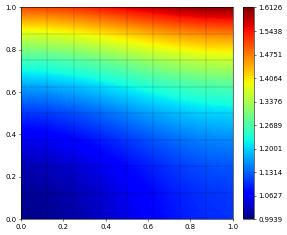

In [28]:
scheme.model.dt = 0.01
time = 0
u_h.interpolate(initial)
while time < (endTime - 1e-6):
    scheme.model.t = time
    u_h_n.assign(u_h)
    scheme.solve(target=u_h)
    time += scheme.model.dt

errors = [np.sqrt(e) for e in integrate(gridView, [l2error,h1error], order=5)]
print('grid size:', gridView.size(0))
print('\t | u_h - u | =', '{:0.5e}'.format(errors[0]))
print('\t | grad(uh - u) | =', '{:0.5e}'.format(errors[1]))
u_h.plot()
gridView.writeVTK('forchheimer', pointdata={'u': u_h, 'l2error': l2error, 'h1error': h1error})

We can refine the grid once and recompute the solution on the finer grid.

grid size: 256
	 | u_h - u | = 2.35195e-06
	 | grad(uh - u) | = 2.49777e-04


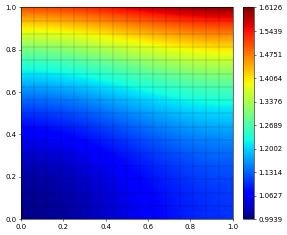

In [29]:
globalRefine(1, gridView.hierarchicalGrid)
scheme.model.dt /= 2
u_h.interpolate(initial)
time = 0
while time < (endTime - 1e-6):
    scheme.model.t = time
    u_h_n.assign(u_h)
    scheme.solve(target=u_h)
    time += scheme.model.dt

errorsFine = [np.sqrt(e) for e in integrate(gridView, [l2error,h1error], order=5)]
print('grid size:', gridView.size(0))
print('\t | u_h - u | =', '{:0.5e}'.format(errorsFine[0]))
print('\t | grad(uh - u) | =', '{:0.5e}'.format(errorsFine[1]))
u_h.plot()

To check that everything is working as expected let's compute the
**experimental order of convergence** (convergence should be cubic for
$L^2$-error and quadratic for the $H^1$-error:

In [30]:
eocs = [ round(np.log(fine/coarse)/np.log(0.5),2)
         for fine,coarse in zip(errorsFine,errors) ]
print("EOCs:",eocs)

EOCs: [2.83, 2.0]


.. index:: Grids; Available Grids

## Listing Available Dune Components
The available realization of a given interface, i.e., the available
grid implementations, depends on the modules found during configuration.
Getting access to all available components is straightforward:

In [31]:
from dune.utility import components
# to get a list of all available components:
components()
# to get for example all available grid implementations:
components("grid")

available categories are:
 discretefunction,function,grid,model,operator,scheme,solver,space,view
available entries for this category are:
entry         function          module      
------------------------------------------
agglomerate   polyGrid          dune.vem.vem
alberta       albertaGrid       dune.grid   
alu           aluGrid           dune.alugrid
aluconform    aluConformGrid    dune.alugrid
alucube       aluCubeGrid       dune.alugrid
alusimplex    aluSimplexGrid    dune.alugrid
oned          onedGrid          dune.grid   
sp            spIsotropicGrid   dune.spgrid 
spanisotropic spAnisotropicGrid dune.spgrid 
spbisection   spBisectionGrid   dune.spgrid 
spisotropic   spIsotropicGrid   dune.spgrid 
ug            ugGrid            dune.grid   
yasp          yaspGrid          dune.grid   
------------------------------------------


.. index:: Spaces; Available Spaces

Available discrete function spaces are:

In [32]:
components("space")

available entries for this category are:
entry          function       module        
------------------------------------------
bbdg           bbdgSpace      dune.vem.vem  
bdm            bdm            dune.fem.space
combined       combined       dune.fem.space
dglagrange     dglagrange     dune.fem.space
dglegendre     dglegendre     dune.fem.space
dglegendrehp   dglegendrehp   dune.fem.space
dgonb          dgonb          dune.fem.space
dgonbhp        dgonbhp        dune.fem.space
finitevolume   finiteVolume   dune.fem.space
lagrange       lagrange       dune.fem.space
lagrangehp     lagrangehp     dune.fem.space
p1bubble       p1Bubble       dune.fem.space
product        product        dune.fem.space
rannacherturek rannacherTurek dune.fem.space
raviartthomas  raviartThomas  dune.fem.space
vem            vemSpace       dune.vem.vem  
------------------------------------------


.. index:: Functions; Available Functions

Available discrete functions are:

In [33]:
components("function")

available entries for this category are:
entry      function          module           
--------------------------------------------
cpp        cppFunction       dune.fem.function
discrete   discreteFunction  dune.fem.function
global     globalFunction    dune.fem.function
levels     levelFunction     dune.fem.function
local      localFunction     dune.fem.function
partitions partitionFunction dune.fem.function
ufl        uflFunction       dune.fem.function
--------------------------------------------


.. index:: Scheme; Available Schemes

Available schemes:

In [34]:
components("scheme")

available entries for this category are:
entry      function         module         
-----------------------------------------
bbdg       bbdgScheme       dune.vem.vem   
dg         dg               dune.fem.scheme
dggalerkin dgGalerkin       dune.fem.scheme
galerkin   galerkin         dune.fem.scheme
h1         h1               dune.fem.scheme
h1galerkin h1Galerkin       dune.fem.scheme
linearized linearized       dune.fem.scheme
rungekutta rungeKuttaSolver dune.femdg     
vem        vemScheme        dune.vem.vem   
-----------------------------------------
